# Zeez 😴

_sleep improvement using wearables and n-of-1 experiments_

[Project Homepage](http://people.ischool.berkeley.edu/~marcelo.queiroz/Zeez/ "Zeez Project Homepage") 

## Data Ingestion, Transformation, and Modeling Notebook

This notebook showcases an ETL pipeline for:
1. ingesting Oura telemetry and Bioloop experiment data via API
2. parsing data into one-record-per-person-per-day form
3. feature engineering
4. model training using H2O
5. model saving for reuse in production

### Distributed, In-Memory Machine Learning

H2O Sparkling Water is designed to be executed as a regular Spark application. It provides a way to initialize H2O services on Spark and access data stored in data structures of Spark and H2O.We have implemented the entire flow in H2O so that we can have a framework in place for getting this project to production.

Advanced Machine Learning for Spark is feasible using H2O. Here we can use the best algorithms for distributed in-memory computing with your existing Spark implementation. After that we can also deploy results in Spark using H2O low-latency pipelines or within Spark for scoring.

In [1]:
# packages for ETL
import json
import numpy as np
import pandas as pd
import os
import zipfile
from zipfile import ZipFile
from datetime import datetime, date
import time
import requests

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# timing facilities
%reload_ext autoreload
%autoreload 2

main_time_counter = time.time()

## ETL Helper Functions

In [3]:
# Helper functions for ETL and feature engineering:

def decode_stacked_json(stacked_json_string, pos=0, decoder=json.JSONDecoder()):
    """Yield multiple JSON objects and restart parsing from the previous position
    Input must be of the form: {'key1': value1, 'key2': value2}{'key3': value3, 'key4': value4"""
    while True:
        try:
            json_object, pos = decoder.raw_decode(stacked_json_string, pos)
        except json.JSONDecodeError:
            break
        yield json_object
       
        
def after_wake_exercise(class_5min,bedtime_end):
    """returns the number of minutes with medium to high MET scores 
    within the first 3 hours of wake-time as a proxy for whether or not exercise 
    occurs after waking up"""
    if isinstance(class_5min,float) or isinstance(bedtime_end, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        wake_hr_min = int(''.join(bedtime_end.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((wake_hr_min - 400)/100)*(60/5))

        #subset observations between wake up and 3 hrs post wake up (24*5=120 min)
        morning_obs = class_5min_list[offset:offset+36]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in morning_obs if obs >=3])*5
        return total_min


def before_sleep_exercise(class_5min,bedtime_start):
    """returns the number of minutes with medium to high MET scores 
    within the last 3 hours of wake-time as a proxy for whether or not exercise 
    occurs in the evening close to bedtime"""
    if isinstance(class_5min,float) or isinstance(bedtime_start, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        sleep_hr_min = int(''.join(bedtime_start.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((sleep_hr_min - 400)/100)*(60/5))

        #subset observations 3 hours before sleep time
        evening_obs = class_5min_list[offset-36:offset]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in evening_obs if obs >=3])*5
        return total_min


def noon_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min,float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 12 (8*12 (5min intervasl in an hr)---#

        offset = 96

        #subset observations between noon and 2 pm
        noon_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in noon_obs if obs >=3])*5
        return total_min
 
    
def evening_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 5pm (13*12) --there are 12 5min intervasl in an hr---#

        offset = 156

        #subset observations between 5pm and 7 pm post wake up
        eve_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in eve_obs if obs >=3])*5
        return total_min


def after_midnight(timestamp_str):
    """indicator for whether or not bedtime started after midnight (in early am hours)"""
    try:
        day, hour = timestamp_str.split('T')
        hr = int(hour[0:2]) #extract hr from timestamp
        if 0 <= hr < 6:
            return 1
        else:
            return 0
    except:
        return np.nan

def age_bin(e):
    """Bins: 20s, 30s, 40s, and 50s +"""
    if  20 <= e < 30:
        return "20s"
    elif 30 <= e < 40:
        return "30s"
    elif 40 <= e < 50:
        return "40s"
    elif e > 50:
        return "50s plus"
    else:
        return np.nan
   
    
def height_bin(e):
    """Bins: 0, 150, 160, 170, 180, 190. In centimeters """
    if  0 < e < 150:
        return "less than 150 cm"
    elif 150 <= e <= 160:
        return "150s"
    elif 160 <= e <= 170:
        return "160s"
    elif 170 <= e <= 180:
        return "170s"
    elif 180 <= e <= 190:
        return "180s"
    elif e > 190:
        return "greater than 190 cm"
    else:
        return np.nan
    
    
def weight_bin(e):
    """Bins: 0, 65, 80, 95. In kilograms"""
    if  0 < e <=65:
        return "less than 65 kg"
    elif 65 <= e <= 80:
        return "65 to 80 kg"
    elif 80 <= e <= 95:
        return "80 to 95 kg"
    elif e > 95:
        return "more than 95 kg"
    else:
        return np.nan

def experiments_recategorize(e):
    '''helper function to recategorize experiment types:
    broader categories will be Magnesium, Chamomile tea, Meditation and Other'''
    if pd.isnull(e):
        return 'None'
    elif 'Meditat' in e:
        return 'Meditation'
    elif 'Magnesium' in e:
        return 'Magnesium'
    elif 'Chamomile' in e:
        return 'Chamomile Tea'
    else:
        return 'Other'

## Extract Data from API

In [6]:
# define data ingestion location
full_path = 'data_ingestion/{}'.format(date.today().strftime('%Y-%m-%d'))
os.makedirs(full_path, exist_ok=True)

# get secret connection credentials
import time
#from dotenv import load_dotenv
import os

# start timing
script_time_start = time.time()

# read .env file
load_dotenv()

# extract .env constants
BIOLOOP_CONNECTION_URL     = os.getenv("BIOLOOP_CONNECTION_URL")
BIOLOOP_CONNECTION_TOKEN   = os.getenv("BIOLOOP_CONNECTION_TOKEN")

# create a simple "log file" on the log ingestion directory. Can be helpful to debug and later on for feature monitoring.
log_file = open(full_path + '/log.txt', 'a+')
log_file.write(time.asctime() + ' - Starting data ingestion process\n')

# if a data file exists, load it, otherwise, create the directory, download a new one and load the DFs:
if not os.path.isfile(full_path + '/raw_dataset.zip'):    
    start = time.time() # time the data ingestion from Memento
    log_file.write(time.asctime() + ' - Day file not found. Starting data download\n')
    
    # try: 
    ACCESS_TOKEN = '###'
    headers = {'Authorization': 'Bearer ' + BIOLOOP_CONNECTION_TOKEN }
    URL = BIOLOOP_CONNECTION_URL

    
    # changed this code to deal with streaming json from 10/20/2019 on. Must double check if this will be the final 
    # format
    data = requests.get(URL, headers=headers).content.decode(encoding='utf-8')

    # save the raw data to disk as zip it to allow re-processing without new download
    zip_file = full_path + '/raw_dataset.zip'
    zipObj = ZipFile(zip_file, 'w', compression=zipfile.ZIP_DEFLATED)
    zipObj.writestr('raw_dataset.txt', data)
    zipObj.close()

    # print('total run time:',time.time() - start)
    log_file.write(time.asctime() + ' - JSON File downloaded and saved. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
    

## Transform To One Dataframe Per Type - Experiments, Sleep, Activity, etc

In [7]:
# define intermediate data frames:
users = pd.DataFrame()
sleep = pd.DataFrame()
readiness = pd.DataFrame()
activity = pd.DataFrame()
experiments = pd.DataFrame()

# timing and logging
start = time.time()
raw_data = str(zipfile.ZipFile(full_path + '/raw_dataset.zip').read('raw_dataset.txt'), encoding='utf-8')
log_file.write(time.asctime() + ' - raw data file loaded. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

start = time.time()
log_file.write(time.asctime() + ' - creating feature space\n')

active_user_counter = 0
xp_counter = 0

for user_json in decode_stacked_json(raw_data):
    # in the stacked json file, each json object corresponds to all data of one user. So here I will perform all 
    # feature transformation that are user-dependent before I append the whole user data to a final data frame.
    user_user = pd.DataFrame.from_records([user_json['userInfo']['userInfo']])
    
    try: # user signup date may be useful to define if a user model is relevant or not:
        user_user['signupDate'] = pd.to_datetime(user_json['signupDate'])
    except KeyError:
        user_user['signupDate'] = np.nan

    # one hot encode gender data:
    try:
        user_user['gender'] = np.where(user_user['gender'] == 'male', True, False)
    except KeyError:
        user_user['gender'] = np.nan

    user_user.rename(columns={'gender':'is_male'}, inplace=True)

    try:
        user_user['age'] = user_user['age']
    except KeyError:
        user_user['age'] = np.nan

    try:
        user_user['height'] = user_user['height']
    except KeyError:
        user_user['height'] = np.nan

    try:
        user_user['weight'] = user_user['weight']
    except KeyError:
        user_user['weight'] = np.nan

    # send to a final users data frame:
    users = users.append(user_user)

    # skip users without sleep records (strictly experiment users, or users of other hardware)
    if len(user_json['sleep']) == 0: continue
    active_user_counter += 1

    # unpack data for each user in a specific data frame
    user_sleep = pd.DataFrame.from_records([i for i in user_json['sleep']])
    user_readiness = pd.DataFrame.from_records([i for i in user_json['readiness']])
    user_activity = pd.DataFrame.from_records([i for i in user_json['activity']])

    # each DF has a `score` feature. Renaming to avoid later confusion:
    user_sleep.rename(columns = {'score':'sleep_score'}, inplace=True)
    user_activity.rename(columns = {'score':'activity_score'}, inplace=True)
    user_readiness.rename(columns = {'score':'readiness_score'}, inplace=True)

    #### ---------- SLEEP FEATURES ----------- ####
    # sleep features normalizing and transformations:
    user_sleep['awake_norm'] = user_sleep['awake']/user_sleep['duration']
    user_sleep['deep_norm'] = user_sleep['deep']/user_sleep['duration']
    user_sleep['light_norm'] = user_sleep['light']/user_sleep['duration']
    user_sleep['onset_latency_norm'] = user_sleep['onset_latency']/user_sleep['duration']
    user_sleep['rem_norm'] = user_sleep['rem']/user_sleep['duration']
    user_sleep['restless_norm'] = user_sleep['light']/100

    # bins for sleep score to Shiraz's models:
    bins = [0, 75, 85, 100]
    names = ['fair', 'good', 'greate']
    user_sleep['good_sleep'] = pd.cut(user_sleep['sleep_score'], bins=bins, labels=names)

    # creating new sleep features:
    user_sleep['summary_date'] = pd.to_datetime(user_sleep['summary_date'])
    user_sleep['user_id'] = user_user['user_id'][0]
    user_sleep['user_date'] = user_sleep['user_id'] + '|' + user_sleep['summary_date'].astype('str')

    user_sleep.set_index('summary_date', inplace = True, drop=False)

    # build D - 1 and D - 2 scores:
    user_sleep['sleep_score_D-1'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['sleep_score_D-2'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['deep_D-1'] = user_sleep['deep'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['deep_D-2'] = user_sleep['deep'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['rem_D-1'] = user_sleep['rem'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['rem_D-2'] = user_sleep['rem'].shift()[user_sleep.index.shift(1,freq='2D')]

    # build 7, 14, and 21 rolling average scores:
    user_sleep['rol_sleep_score_7d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    # shifted 7 day score rolled feature. This is target feature to predict your average 7 days ahead
    user_sleep['avg_sleep_score_next_week'] = user_sleep['rol_sleep_score_7d'].shift(-1,freq='7D')

    user_sleep['rol_sleep_score_14d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=14, min_periods=10).mean()
    user_sleep['rol_sleep_score_21d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=21, min_periods=17).mean()

    # build other 7-day rolling features for peter's models later:
    user_sleep['rol_bedtime_end_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                            window=7, min_periods=3).mean()
    user_sleep['rol_bedtime_start_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                    window=7, min_periods=3).mean()
    user_sleep['rol_onset_latency_7d'] = pd.DataFrame.rolling(user_sleep['onset_latency'].shift(1, freq='1D'),
                                                              window=7, min_periods=3).mean()
    user_sleep['rol_duration_7d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                         window=7, min_periods=3).mean()

    # build is_traveling
    user_sleep['is_traveling'] = np.where(user_sleep['timezone'] == 
                                                    user_sleep['timezone'].value_counts().idxmax(), False, True)
    
    user_sleep['tz_delta'] = (user_sleep['timezone'] - user_sleep['timezone'].value_counts().idxmax()) / (-60)
    
    # build rol_bedtime_start_21d
    user_sleep['rol_bedtime_start_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    # build avg_bedtime_start_delta, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_start_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_start_dev'] = (user_sleep['bedtime_start_delta'] - user_sleep['rol_bedtime_start_21d'])/\
                                      user_sleep['rol_bedtime_start_std_21d']

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 0, 
                                                        np.ceil(user_sleep['bedtime_start_dev']),
                                                        np.floor(user_sleep['bedtime_start_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] <= -3,-3, user_sleep['bedtime_start_dev'])

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 3,3,
                                                        user_sleep['bedtime_start_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_start_dev'])

    user_sleep.rename(columns = { 'bedtime_start_dev_-3.0':'bedtime_start_dev-3', 
                                  'bedtime_start_dev_-2.0':'bedtime_start_dev-2', 
                                  'bedtime_start_dev_-1.0': 'bedtime_start_dev-1',
                                  'bedtime_start_dev_1.0': 'bedtime_start_dev+1',
                                  'bedtime_start_dev_2.0': 'bedtime_start_dev+2',
                                  'bedtime_start_dev_3.0': 'bedtime_start_dev+3'},
                                  inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_start_21d','rol_bedtime_start_std_21d'], axis = 1, inplace = True)

    # build avg_bedtime_end_delta, create dummy variables for deviation. (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_end_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_bedtime_end_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_end_dev'] = (user_sleep['bedtime_end_delta'] - user_sleep['rol_bedtime_end_21d'])/\
                                    user_sleep['rol_bedtime_end_std_21d']

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 0, 
                                             np.ceil(user_sleep['bedtime_end_dev']),
                                             np.floor(user_sleep['bedtime_end_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] <= -3,-3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 3,3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_end_dev'])

    user_sleep.rename(columns = {'bedtime_end_dev_-3.0':'bedtime_end_dev-3', 
                                 'bedtime_end_dev_-2.0':'bedtime_end_dev-2', 
                                 'bedtime_end_dev_-1.0': 'bedtime_end_dev-1',
                                 'bedtime_end_dev_1.0': 'bedtime_end_dev+1',
                                 'bedtime_end_dev_2.0': 'bedtime_end_dev+2',
                                 'bedtime_end_dev_3.0': 'bedtime_end_dev+3'},
                                 inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_end_21d','rol_bedtime_end_std_21d'], axis = 1, inplace = True)

    # build avg_duration, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_duration_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_duration_std_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['duration_dev'] = (user_sleep['duration'] - user_sleep['rol_duration_21d'])/\
                                 user_sleep['rol_duration_std_21d']

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 0, 
                                          np.ceil(user_sleep['duration_dev']),
                                          np.floor(user_sleep['duration_dev']))

    # cap standard deviations to -3 or +3:
    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] <= -3,-3, user_sleep['duration_dev'])

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 3,3, user_sleep['duration_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['duration_dev'])

    user_sleep.rename(columns = {'duration_dev_-3.0':'duration_dev-3', 
                              'duration_dev_-2.0':'duration_dev-2', 
                              'duration_dev_-1.0':'duration_dev-1',
                              'duration_dev_1.0': 'duration_dev+1',
                              'duration_dev_2.0': 'duration_dev+2',
                              'duration_dev_3.0': 'duration_dev+3'},
                              inplace = True)

    user_sleep.drop(labels = ['rol_duration_21d','rol_duration_std_21d'], axis = 1, inplace = True)

    # build dummy to day of the week.
    user_sleep['weekday'] = user_sleep['summary_date'].dt.weekday

    # build is_workday
    user_sleep['is_workday'] = np.where(user_sleep['weekday'] < 5, True, False)

    # one-hot encode weekdays
    user_sleep = pd.get_dummies(user_sleep, columns=['weekday'])

    user_sleep.rename(columns = {'weekday_0':'weekday_mon', 
                              'weekday_1':'weekday_tue', 
                              'weekday_2': 'weekday_wed',
                              'weekday_3': 'weekday_thu',
                              'weekday_4': 'weekday_fri',
                              'weekday_5': 'weekday_sat',
                              'weekday_6': 'weekday_sun'}, 
                              inplace = True)

    #rolling actionable sleep features
    sleep_vars_to_roll = ['onset_latency','duration','is_traveling','score_disturbances']
    
    for feature in sleep_vars_to_roll :
        user_sleep['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_sleep[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    
    #---Week-over-Week sleep behavior changes as proxy for sleep routine---#
    user_sleep['rol_onset_latency_7d_WoW'] = user_sleep['rol_onset_latency_7d'].pct_change(periods=7)
    user_sleep['rol_duration_7d_WoW'] = user_sleep['rol_duration_7d'].pct_change(periods=7)
    user_sleep['rol_score_disturbances_7d_WoW'] = user_sleep['rol_score_disturbances_7d'].pct_change(periods=7)
    user_sleep['rol_bedtime_start_delta_7d_WoW'] = user_sleep['rol_bedtime_start_delta_7d'].pct_change(periods=7)
    
    #sleep routine as the mean absolute value of WoW variables
    user_sleep['sleep_routine_score'] = (
    np.absolute(user_sleep['rol_onset_latency_7d_WoW']) + 
    np.absolute(user_sleep['rol_duration_7d_WoW']) +
    np.absolute(user_sleep['rol_score_disturbances_7d_WoW'])+
    np.absolute(user_sleep['rol_bedtime_start_delta_7d_WoW']))/4
    
    user_sleep.set_index('user_date', inplace = True)
    sleep = sleep.append(user_sleep)


    #### ---------- ACTIVITY FEATURES ----------- ####
    # Creating the new activity related features. Because several activity features depends on user info and/or 
    # sleep features, I will add the features needed here:
    user_activity['user_date'] = user_user['user_id'][0] + '|' + user_activity['summary_date'].astype('str')

    user_activity['age'] = user_user['age'][0]
    user_activity['height'] = user_user['height'][0]
    user_activity['weight'] = user_user['weight'][0]
    user_activity['is_male'] = user_user['is_male'][0]

    user_activity['summary_date'] = pd.to_datetime(user_activity['summary_date'])   
    user_activity = user_activity.merge(user_sleep[['bedtime_start', 'bedtime_end', 'summary_date']], 
                                        on='summary_date', how='left')

    user_activity.set_index('summary_date', inplace = True, drop=False)

    user_activity['met_min_medium_plus'] = user_activity['met_min_medium'] + \
                                                    user_activity['met_min_high']

    user_activity['age_bin'] = user_activity['age'].apply(age_bin)
    user_activity['height_bin'] = user_activity['height'].apply(height_bin)
    user_activity['weight_bin'] = user_activity['weight'].apply(weight_bin)
    user_activity['sleep_afterMidnight'] = user_activity['bedtime_start'].apply(after_midnight)
    user_activity['afterwake_exercise_min'] = [after_wake_exercise(c,b) for c,b in \
                                               zip(user_activity['class_5min'],
                                                   user_activity['bedtime_end'])]
    user_activity['beforesleep_exercise_min'] = [before_sleep_exercise(c,b) for c,b in \
                                                 zip(user_activity['class_5min'],
                                                     user_activity['bedtime_start'])]
    user_activity['noon_exercise_min'] = user_activity['class_5min'].apply(noon_exercise)
    user_activity['eve_exercise_min'] = user_activity['class_5min'].apply(evening_exercise)

    # actionable activity variables that will be rolled within a 7 day window
    activity_vars_to_roll = ['cal_total', 'high', 'medium','steps','inactive', 
                             'non_wear', 'activity_score','met_min_medium','sleep_afterMidnight',
                             'met_min_high', 'met_min_medium_plus','score_move_every_hour',
                             'score_stay_active', 'beforesleep_exercise_min',
                             'afterwake_exercise_min','noon_exercise_min', 'eve_exercise_min']

    for feature in activity_vars_to_roll :
        user_activity['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_activity[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    #---Week-over-Week activity behavior changes as proxy for activity routine---#
    #note; these variables are already recorded on a last 7 day average per API so we didn't need to roll them
    user_activity['score_training_frequency_WoW'] = user_activity['score_training_frequency'].pct_change(periods=7)
    user_activity['score_training_volume_WoW'] = user_activity['score_training_volume'].pct_change(periods=7)
    user_activity['score_meet_daily_targets_WoW'] = user_activity['score_meet_daily_targets'].pct_change(periods=7)
    user_activity['score_recovery_time_WoW'] = user_activity['score_recovery_time'].pct_change(periods=7)
    
    #activity routine as the mean absolute value of WoW variables
    user_activity['activity_routine_score'] = (
    np.absolute(user_activity['score_training_frequency_WoW']) + 
    np.absolute(user_activity['score_training_volume_WoW']) +
    np.absolute(user_activity['score_meet_daily_targets_WoW'])+
    np.absolute(user_activity['score_recovery_time_WoW']))/4


    user_activity.set_index('user_date', inplace = True)
    activity = activity.append(user_activity)


    #### ---------- READINESS FEATURES ----------- ####
    # As we are not doing any transformation in the readiness data frame, append directly to the final one:
    user_readiness['user_date'] = user_user['user_id'][0] + '|' + user_readiness['summary_date'].astype('str')
    user_readiness.set_index('user_date', inplace=True)
    readiness = readiness.append(user_readiness)

    #### ---------- EXPERIMENTS FEATURES ----------- ####
    # Not all users had experiments done:
    if len(user_json['previousExperiments']) != 0:
    # extract and flattens only the features needed: date, treatment, effect, and if if is a baseline date.
    # NOTE: In Memento one experiment have one treatment, but can have multiple effects, however we are not interested
    #       in the intermediate effect, but on the effect on final sleep score. Therefore, we will ignore the effects
    #       the users set and incorporate the experiments to the main data frame.
      
        user_experiments = pd.DataFrame.from_records([i for i in user_json['previousExperiments']])
        xp_counter += len(user_json['previousExperiments'])
    
        try:
            treatment_randomized = pd.io.json.json_normalize(user_experiments.design[0]).isRandomized[0]
        except:
            treatment_randomized = 0
        
        # parse experiment types:
        experiment_type = user_experiments.experimentName[0].split('(')[0]
        
        # unroll checkIns object
        checkIns = pd.DataFrame()
        checkIns = pd.io.json.json_normalize(user_experiments.checkIns[0])
        
        # add experiment randomization, type, and user_ids to checkins
        checkIns['treatment_randomized'] = treatment_randomized
        checkIns['experiment_type'] = experiment_type
        checkIns['user_id'] = user_user['user_id'][0]
        
        # filter out only the necessary columns (helps the join later)
        checkIns = checkIns.filter(['date','user_id','treatment_randomized','experiment_type','compliance'])
    
        checkIns['user_date'] = checkIns['user_id'] + '|' + checkIns['date'].astype('str')
        checkIns.set_index('user_date', inplace=True)
    
        experiments = experiments.append(checkIns)

## Log Results

In [8]:
# log the time and main descriptive statistics of the final datasets for data governance purposes
log_file.write(time.asctime() + ' - Feature space created. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
log_file.write(time.asctime() + '     - Total active users: ' + str(active_user_counter) + '\n')
log_file.write(time.asctime() + '     - ACTIVITY data frame shape: ' + str(activity.shape) + '\n')
log_file.write(time.asctime() + '     - SLEEP data frame shape: ' + str(sleep.shape) + '\n')
log_file.write(time.asctime() + '     - READINESS data frame shape: ' + str(readiness.shape) + '\n')
log_file.write(time.asctime() + '     - EXPERIMENTS data frame shape: ' + str(experiments.shape) + '\n')
log_file.write(time.asctime() + '       - finished EXPERIMENTS count: ' + str(xp_counter) + '\n')
log_file.write(time.asctime() + '       - finished EXPERIMENTS user-days: ' + str(experiments.shape[0]) + '\n')

69

## Merge To One-Record-Per-Person-Per-Day, and Save

In [9]:
start = time.time()

# Save each DF as a csv file (case needed to work on a single file in teh future
users_file_path = full_path + '/users_data.csv'
sleep_file_path = full_path + '/sleep_data.csv'
readiness_file_path = full_path + '/readiness_data.csv'
activity_file_path = full_path + '/activity_data.csv'
df_gold_file_path = full_path + '/gold.csv'
experiments_file_path = full_path + '/experiments.csv'

users.to_csv(users_file_path, index=None, encoding='utf-8')
sleep.to_csv(sleep_file_path, index_label='user_date', encoding='utf-8')
readiness.to_csv(readiness_file_path, index_label='user_Date', encoding='utf-8')
activity.to_csv(activity_file_path, index_label='user_Date', encoding='utf-8')
experiments.to_csv(experiments_file_path, index=None, encoding='utf-8')

# Drop duplicate columns and merge all dfs in a big "gold" df. Will keep only one of the summary dates (readiness)
readiness.drop(['period_id'], axis=1, inplace=True)
sleep.drop(['summary_date', 'timezone','period_id'], axis=1, inplace=True)
activity.drop(['bedtime_start', 'bedtime_end', 'summary_date', 'timezone', 'total'], axis=1, inplace=True)
experiments.drop(['date', 'user_id'], axis=1, inplace=True)

# merge all data frames into one. NOTE: sleep, activity and readiness are inner joins, so only days with all records are
# used. For experiments we use outer join, so user_days without experiments will have NaN on those features.
df_gold = sleep.merge(activity, left_index=True, right_index=True)
df_gold = df_gold.merge(readiness, left_index=True, right_index=True)
df_gold = df_gold.merge(experiments, how='outer', left_index=True, right_index=True)

#---adding experiment category and user_id indicators---#

df_gold['experiment_category'] = df_gold['experiment_type'].apply(experiments_recategorize)
df_gold = pd.get_dummies(df_gold, columns=['experiment_category','user_id'])

#binarizing next week's sleep score: 0 if decrease, 1 otherwise
df_gold['avg_sleep_score_next_week_binarized'] = (df_gold['avg_sleep_score_next_week'] >= df_gold['rol_sleep_score_7d']).astype(int)

#---writing out to file----#
df_gold.to_csv(df_gold_file_path, index_label='user_date', encoding='utf-8')

log_file.write(time.asctime() + '     - GOLD data frame shape: ' + str(df_gold.shape) + '\n')

# zip all files in a gold_dataset.zip
files = [users_file_path, sleep_file_path, readiness_file_path,
         activity_file_path, df_gold_file_path, experiments_file_path]

files_names = ['users_data.csv', 'sleep_data.csv', 'readiness_data.csv',
         'activity_data.csv', 'gold.csv', 'experiments.csv']

zip_file = full_path + '/gold_dataset.zip'
zipObj = zipfile.ZipFile(zip_file, mode='w')

for i in range(len(files)):
    zipObj.write(files[i], arcname=files_names[i])    

zipObj.close()

## Log Results

In [10]:
# delete unzipped CSVs
for i in range(len(files)):
    os.remove(files[i])
    
log_file.write(time.asctime() + ' - All data frames saved and zipped. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

log_file.write(time.asctime() + ' - Total time spent in the routine: ' + f'{(time.time() - main_time_counter):.1f}' + ' secs.\n')
log_file.write(time.asctime() + ' ##### ----- DATA INGESTION ROUTINE FINALIZED ----- #####\n\n')

log_file.close()

## Loading Data for Modeling


In [11]:
#Unzipping and Reading in Gold Dataset
import zipfile
unzip_file_path = full_path + '/unzipped_data'
os.makedirs(unzip_file_path, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_file_path)

In [12]:
df_gold = pd.read_csv('data_ingestion/'+format(date.today().strftime('%Y-%m-%d'))+'/unzipped_data/gold.csv',parse_dates = ['summary_date'])

## Data Shape and Columns

In [13]:
# show dimensions of the training and test data at this stage
print("\nTrain Set Shape:")
print(df_gold.shape)

print("\nTraining Data Columns:")
for i in df_gold.columns:
    print(i,end=", ")


Train Set Shape:
(28379, 275)

Training Data Columns:
user_date, avg_sleep_score_next_week, awake, awake_norm, bedtime_end, bedtime_end_delta, bedtime_end_dev+1, bedtime_end_dev+2, bedtime_end_dev+3, bedtime_end_dev-1, bedtime_end_dev-2, bedtime_end_dev-3, bedtime_start, bedtime_start_delta, bedtime_start_dev+1, bedtime_start_dev+2, bedtime_start_dev+3, bedtime_start_dev-1, bedtime_start_dev-2, bedtime_start_dev-3, breath_average, deep, deep_D-1, deep_D-2, deep_norm, duration, duration_dev+1, duration_dev+2, duration_dev+3, duration_dev-1, duration_dev-2, duration_dev-3, duration_dev_0.0, efficiency, good_sleep, hr_5min, hr_average, hr_lowest, hypnogram_5min, is_longest, is_traveling, is_workday, light, light_norm, midpoint_at_delta, midpoint_time, onset_latency, onset_latency_norm, rem, rem_D-1, rem_D-2, rem_norm, restless, restless_norm, rmssd, rmssd_5min, rol_bedtime_end_delta_7d, rol_bedtime_start_delta_7d, rol_bedtime_start_delta_7d_WoW, rol_duration_7d, rol_duration_7d_WoW, rol_

In [14]:
df_gold.shape

(28379, 275)

#### Production implementation

The following section is fully implmented using H2O. The objective is to have code ready for a production release that will allow this solution to benefit from Spark and Hive infrastructure. The following section is annotated to demonstrate a set of H2O models that will allow for a production release team to be able to take the sklearn version and continue to develop a scalable solution.

In [25]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,27 days 19 hours 55 mins
H2O cluster timezone:,UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,4 months and 21 days !!!
H2O cluster name:,H2O_from_python_unknownUser_m7x25t
H2O cluster total nodes:,1
H2O cluster free memory:,5.417 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"locked, healthy"


#### Load Data

We use the same analytical ready dataset as we have used for the sklearn version of the models here.

In [26]:
df_gold.shape

(28379, 275)

In [27]:
df_gold.to_csv('dataset.csv', encoding='utf-8')

In [28]:
# select columns for inclusion in modeling
model_columns = [# time index
                'summary_date',
                # features constructed from Oura ring telemetry
                'rol_sleep_afterMidnight_7d','rol_onset_latency_7d',
                'rol_bedtime_start_delta_7d','rol_steps_7d','rol_is_traveling_7d',
                'score_training_frequency', 'score_training_volume',
                'activity_routine_score','sleep_routine_score',
                'rol_score_disturbances_7d','rol_sleep_score_7d',
                # features gathered on Oura signup
                'is_male','age',
                # binary features constructed from Bioloop experiments
                'experiment_category_Chamomile Tea',
                'experiment_category_Magnesium',
                'experiment_category_Meditation',
                # outcome feature
                'avg_sleep_score_next_week'
                ]

# keep only selected columns
mod_df = df_gold.filter(model_columns)

# splitting training and test set by recency
train = mod_df[mod_df['summary_date'] <= pd.Timestamp(2019, 9, 1, 12)]
test = mod_df[mod_df['summary_date'] > pd.Timestamp(2019, 9, 1, 12)]

# dropping summary date since its not needed after train/test split on recency
train = train.drop(['summary_date'],axis=1)
test = test.drop(['summary_date'],axis=1)

# dropping NaNs
train = train.dropna()
test = test.dropna()

## Fit and Evaluate Random Forest Model

#drop summary date from features
features = [f for f in model_columns if f not in {'summary_date',
                                                  'avg_sleep_score_next_week'}]


In [29]:
train.shape , test.shape

((14700, 17), (5433, 17))

In [30]:
train.head(3)

,rol_sleep_afterMidnight_7d,rol_onset_latency_7d,rol_bedtime_start_delta_7d,rol_steps_7d,rol_is_traveling_7d,score_training_frequency,score_training_volume,activity_routine_score,sleep_routine_score,rol_score_disturbances_7d,rol_sleep_score_7d,is_male,age,experiment_category_Chamomile Tea,experiment_category_Magnesium,experiment_category_Meditation,avg_sleep_score_next_week
268,1.0,1110.000000,13259.714286,8319.571429,0.142857,40.0,79.0,0.445969,0.169693,76.428571,75.571429,1.0,28.0,0,0,0,78.571429
270,1.0,1050.000000,12918.857143,9334.142857,0.000000,71.0,96.0,0.248712,0.151036,79.285714,79.285714,1.0,28.0,0,0,0,76.142857
271,1.0,1157.142857,12447.571429,9234.000000,0.000000,71.0,96.0,0.138569,0.141902,77.857143,78.428571,1.0,28.0,0,0,0,73.857143


In [31]:
### Save the train and test to convert to H2OFrame

train.to_csv('train.csv', encoding='utf-8')
test.to_csv('test.csv', encoding='utf-8')

In [32]:

# initialize Random Forest
rf_regr = RandomForestRegressor(n_estimators = 100)

# train the model
rf_regr.fit(train[features],train['avg_sleep_score_next_week'])
rf_reg_pred = rf_regr.predict(test[features])

# test performance of the model
print('R2 of: ',r2_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MSE of: ', mean_squared_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MAE of: ', mean_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Explained Variance:', explained_variance_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Median Absolute Error',median_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))

NameError: name 'RandomForestRegressor' is not defined

In [33]:
# Load data into H2O

data_path = 'train.csv'
train = h2o.import_file(data_path)
train = train.drop('C1')
data_path = 'test.csv'
test = h2o.import_file(data_path)
test = test.drop('C1')

predictors = list(set(train.col_names) - set('avg_sleep_score_next_week'))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
train.shape , test.shape

((14700, 17), (5433, 17))

Now that we have cleaned our data and added new columns, we train a model to predict bad loans. First split our loans data into train and test.

In [116]:
# h2o Python API with specific classes
import h2o                                        
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
help(H2OGradientBoostingEstimator)
help(h2o.import_file)

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
import shap          # for visualizing Shapley values

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

Help on class H2OGradientBoostingEstimator in module h2o.estimators.gbm:

class H2OGradientBoostingEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Gradient Boosting Machine
 |  
 |  Builds gradient boosted trees on a parsed data set, for regression or classification.
 |  The default distribution function will guess the model type based on the response column type.
 |  Otherwise, the response column must be an enum for "bernoulli" or "multinomial", and numeric
 |  for all other distributions.
 |  
 |  Method resolution order:
 |      H2OGradientBoostingEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      h2o.utils.backward_compatibility.BackwardsCompatibleBase
 |      h2o.base.Keyed
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Construct a new model instance.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:



Help on function import_file in module h2o.h2o:

import_file(path=None, destination_frame=None, parse=True, header=0, sep=None, col_names=None, col_types=None, na_strings=None, pattern=None, skipped_columns=None, custom_non_data_line_markers=None)
    Import a dataset that is already on the cluster.
    
    The path to the data must be a valid path for each node in the H2O cluster. If some node in the H2O cluster
    cannot see the file, then an exception will be thrown by the H2O cluster. Does a parallel/distributed
    multi-threaded pull of the data. The main difference between this method and :func:`upload_file` is that
    the latter works with local files, whereas this method imports remote files (i.e. files local to the server).
    If you running H2O server on your own machine, then both methods behave the same.
    
    :param path: path(s) specifying the location of the data to import or a path to a directory of files to import
    :param destination_frame: The unique hex k

In [37]:
# initialize GBM model
rf_h2o = H2ORandomForestEstimator(
    model_id="rf_h2o",
    ntrees=200,
    max_depth=30,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000)


gbm_h2o = H2OGradientBoostingEstimator(
    ntrees=30,
    learn_rate=0.3,
    max_depth=10,
    sample_rate=0.7,
    col_sample_rate=0.7,
    stopping_rounds=2,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    score_each_iteration=True,
    model_id="gbm_h2o",
    seed=2000000
)




drf Model Build progress: |███████████████████████████████████████████████| 100%


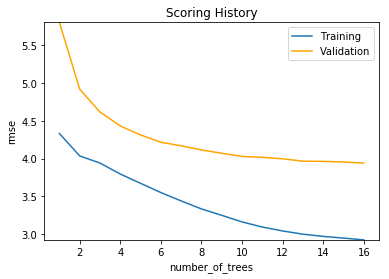

In [40]:
rf_h2o.train(y='avg_sleep_score_next_week', x=predictors, training_frame=train, validation_frame=test)

%matplotlib inline
rf_h2o.plot()

gbm Model Build progress: |███████████████████████████████████████████████| 100%


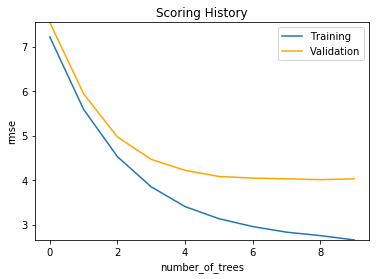

In [41]:
gbm_h2o.train(y='avg_sleep_score_next_week', x=predictors, training_frame=train, validation_frame=test)

%matplotlib inline
gbm_h2o.plot()

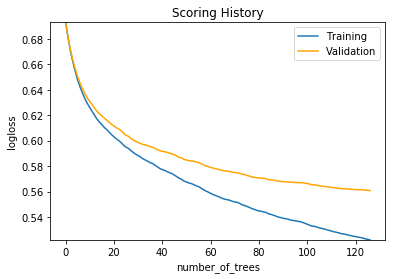

In [355]:
%matplotlib inline
model.plot()

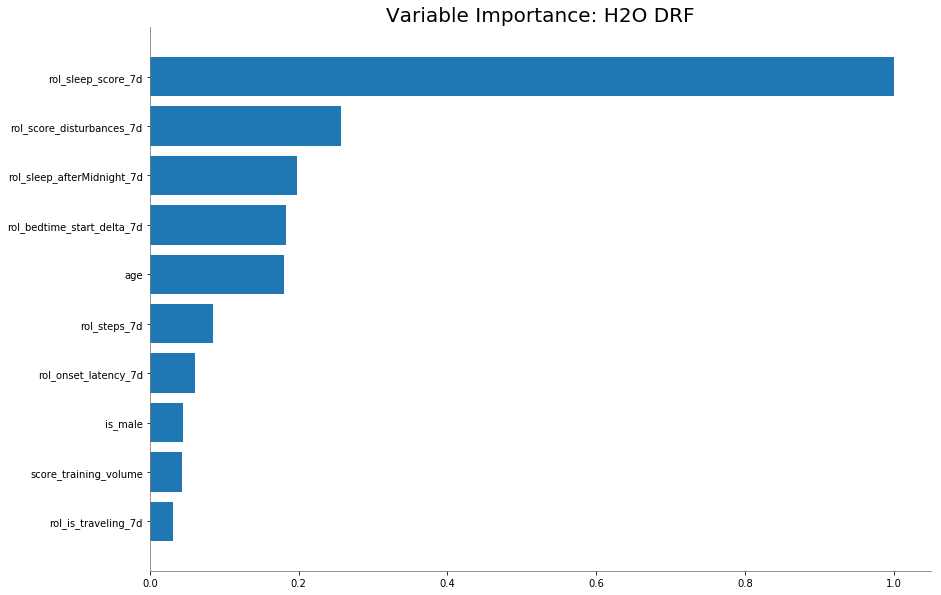

In [45]:
rf_h2o.varimp_plot()

In [46]:
perf_cls = rf_h2o.model_performance()
perf_cls


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 8.542808215278084
RMSE: 2.9228082754908993
MAE: 2.1143570882618694
RMSLE: 0.03830336137763912
Mean Residual Deviance: 8.542808215278084


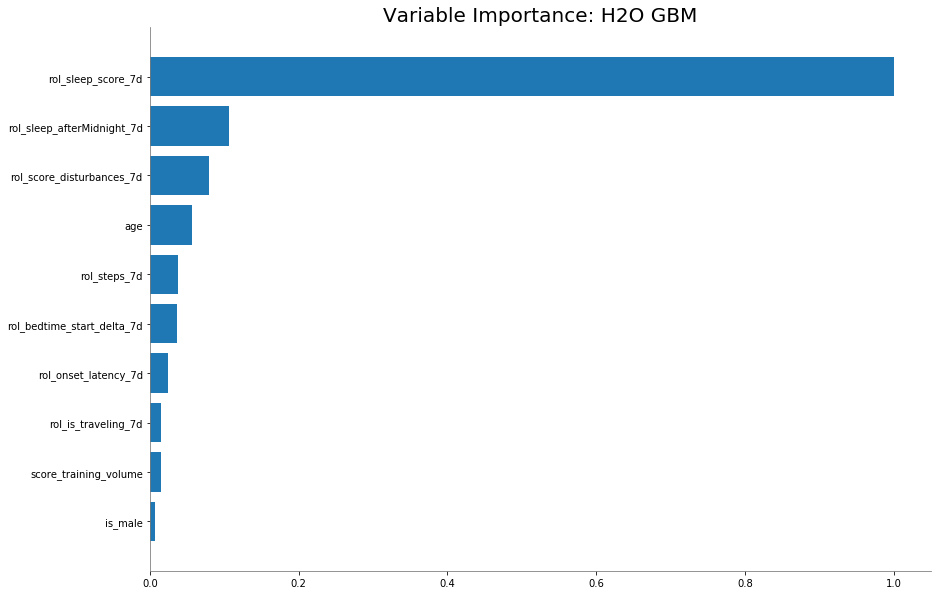

In [47]:
gbm_h2o.varimp_plot()

In [57]:
perf_cls = gbm_h2o.model_performance(test)
perf_cls


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 16.221246237746723
RMSE: 4.027560829800926
MAE: 3.115253196980419
RMSLE: 0.05420365334888549
Mean Residual Deviance: 16.221246237746723


xgboost Model Build progress: |███████████████████████████████████████████| 100%


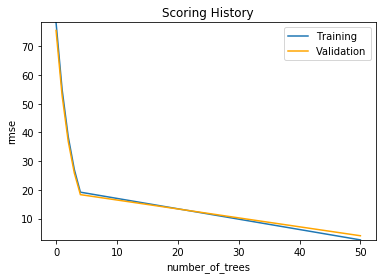

In [50]:
from h2o.estimators import H2OXGBoostEstimator

param = {
      "ntrees" : 50
    , "nfolds" : 10
    , "seed": 20
}
xgb_h2o = H2OXGBoostEstimator(**param)

xgb_h2o.train(y='avg_sleep_score_next_week', x=predictors, training_frame=train, validation_frame=test)

%matplotlib inline
xgb_h2o.plot()



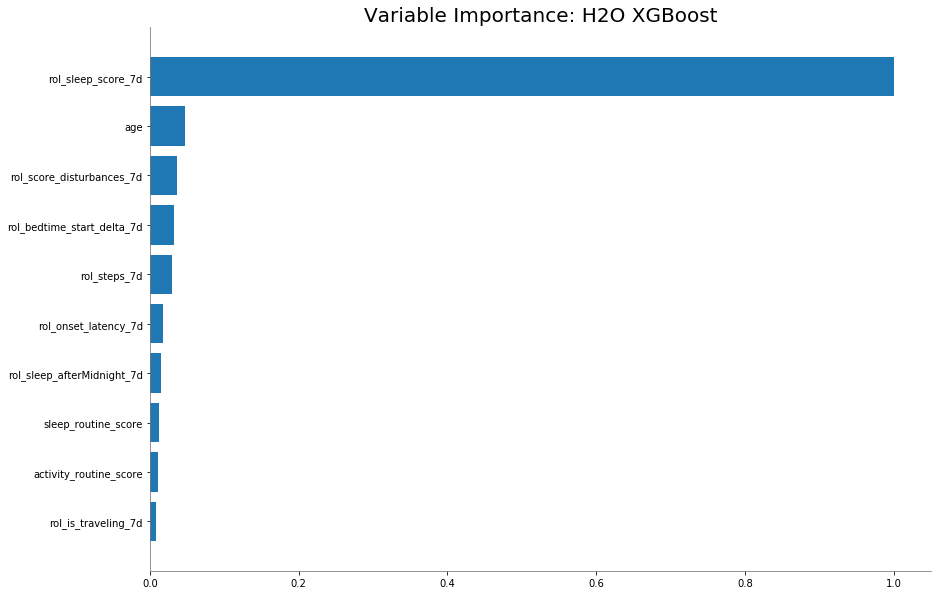

In [51]:
xgb_h2o.varimp_plot()

In [56]:
perf_cls = xgb_h2o.model_performance(test)
perf_cls


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 16.188765676599036
RMSE: 4.023526522417746
MAE: 3.131884827131991
RMSLE: 0.054478834459383
Mean Residual Deviance: 16.188765676599036


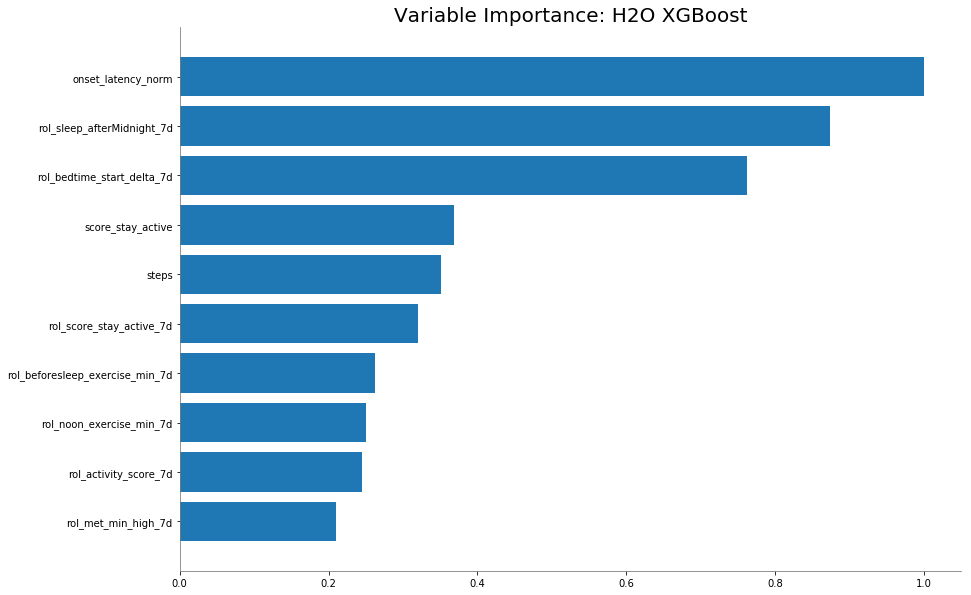

In [362]:
xgboost_model.varimp_plot()

In [55]:
perf_cls = xgb_h2o.model_performance(test)
perf_cls


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 16.188765676599036
RMSE: 4.023526522417746
MAE: 3.131884827131991
RMSLE: 0.054478834459383
Mean Residual Deviance: 16.188765676599036


#### H2O AutoML


Although H2O has made it easy for non-experts to experiment with machine learning, there is still a fair bit of knowledge and background in data science that is required to produce high-performing machine learning models. Deep Neural Networks in particular are notoriously difficult for a non-expert to tune properly. In order for machine learning software to truly be accessible to non-experts, we have designed an easy-to-use interface which automates the process of training a large selection of candidate models. H2O’s AutoML can also be a helpful tool for the advanced user, by providing a simple wrapper function that performs a large number of modeling-related tasks that would typically require many lines of code, and by freeing up their time to focus on other aspects of the data science pipeline tasks such as data-preprocessing, feature engineering and model deployment.

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles – one based on all previously trained models, another one on the best model of each family – will be automatically trained on collections of individual models to produce highly predictive ensemble models which, in most cases, will be the top performing models in the AutoML Leaderboard.

In [60]:
%%time
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=5, 
                max_runtime_secs_per_model=60, 
                seed=20)
aml.train(y='avg_sleep_score_next_week', x=predictors, training_frame=train, validation_frame=test)


AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 3.16 s, sys: 316 ms, total: 3.48 s
Wall time: 4min 7s


In [62]:
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows) # Entire leaderboardm,

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_1_AutoML_20191207_191122,6.53626,2.55661,6.53626,1.86373,0.0335617
DRF_1_AutoML_20191207_190500,6.53626,2.55661,6.53626,1.86373,0.0335617
GLM_grid_1_AutoML_20191207_190500_model_1,15.3992,3.92418,15.3992,3.01055,0.0514595
GLM_grid_1_AutoML_20191207_191122_model_1,15.3992,3.92418,15.3992,3.01055,0.0514595
XGBoost_3_AutoML_20191207_191122,57.7908,7.60202,57.7908,6.61688,0.0984769
XGBoost_2_AutoML_20191207_190500,61.8911,7.86709,61.8911,7.02558,0.102054
XGBoost_2_AutoML_20191207_191122,64.7435,8.04634,64.7435,7.03069,0.104885
XGBoost_1_AutoML_20191207_190500,72.1924,8.49661,72.1924,7.42521,0.111184
XGBoost_3_AutoML_20191207_190500,76.703,8.75803,76.703,7.67674,0.114671
XGBoost_1_AutoML_20191207_191122,80.1749,8.95404,80.1749,7.90464,0.1175


In [64]:
perf_cls = aml.leader.model_performance(test_data=test)
perf_cls


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 14.566758677768382
RMSE: 3.816642330343306
MAE: 2.9681689355892256
RMSLE: 0.051435801930313114
Mean Residual Deviance: 14.566758677768382


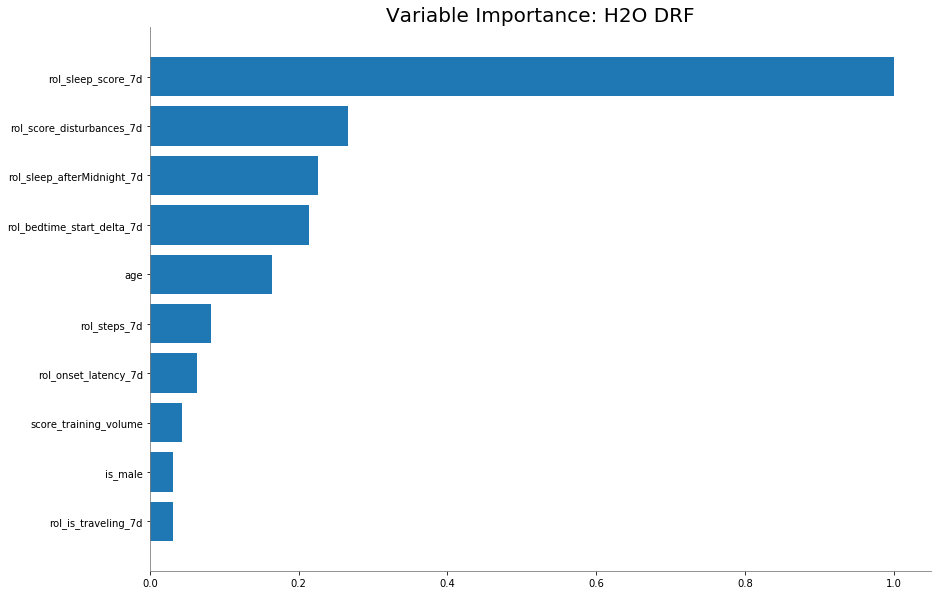

In [65]:
aml.leader.varimp_plot()

In [68]:
sh = aml.leader.score_history()
sh = pd.DataFrame(sh)


In [69]:
sh.columns

Index(['', 'timestamp', 'duration', 'number_of_trees', 'training_rmse',
       'training_mae', 'training_deviance', 'validation_rmse',
       'validation_mae', 'validation_deviance'],
      dtype='object')

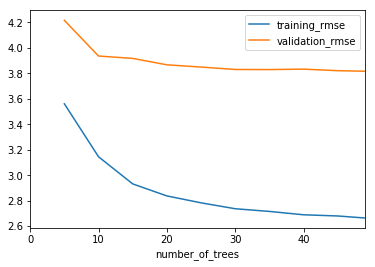

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline 
# plot training training_rmse and training_mae
sh.plot(x='number_of_trees', y = ['training_rmse','validation_rmse'])

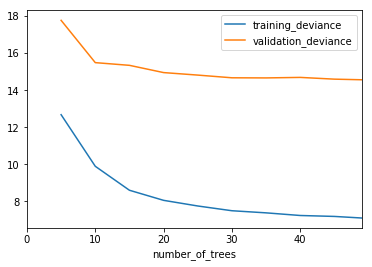

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline 
# plot training training_rmse and training_mae
sh.plot(x='number_of_trees', y = ['training_deviance','validation_deviance'])

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


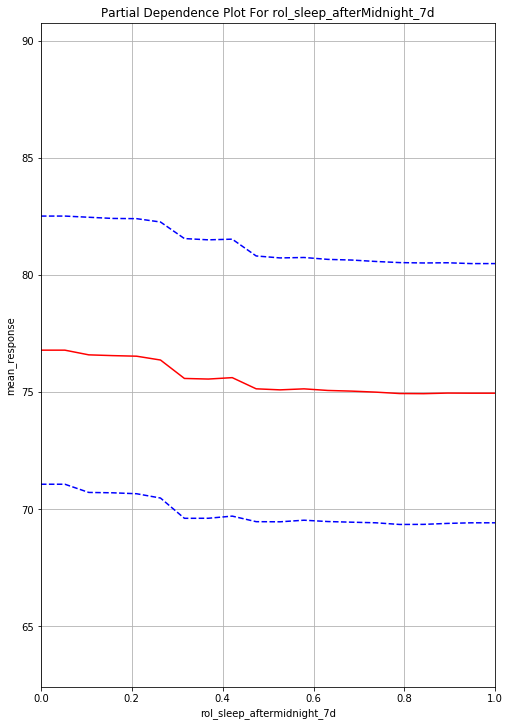

In [132]:
pdp = aml.leader.partial_plot(cols=["rol_sleep_afterMidnight_7d"], data=test)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


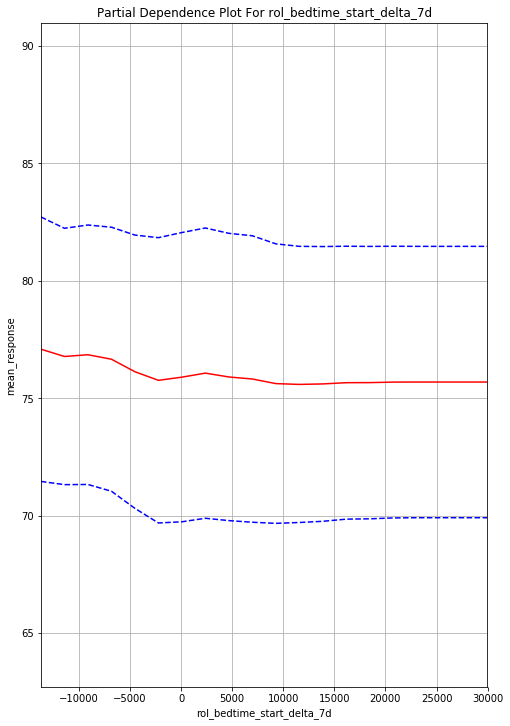

In [133]:
pdp = aml.leader.partial_plot(cols=["rol_bedtime_start_delta_7d"], data=test)

## Saving an H2O Model


In Python, we can save a model locally or to HDFS using the `h2o.saveModel` (Python) function . This function accepts the model object and the file path. If no path is specified, then the model will be saved to the current working directory. After the model is saved, we can load it using the `h2o.load_model` (Python) function.

In [134]:
# save the model
model_path = h2o.save_model(model=aml.leader, path="h2o_model", force=True)

print(model_path)


/jupyter/h2o_model/DRF_1_AutoML_20191207_191122


In [135]:
# load the model
saved_model = h2o.load_model(model_path)

In [137]:
saved_model.model_performance(test_data=test)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 14.566758677768382
RMSE: 3.816642330343306
MAE: 2.9681689355892256
RMSLE: 0.051435801930313114
Mean Residual Deviance: 14.566758677768382


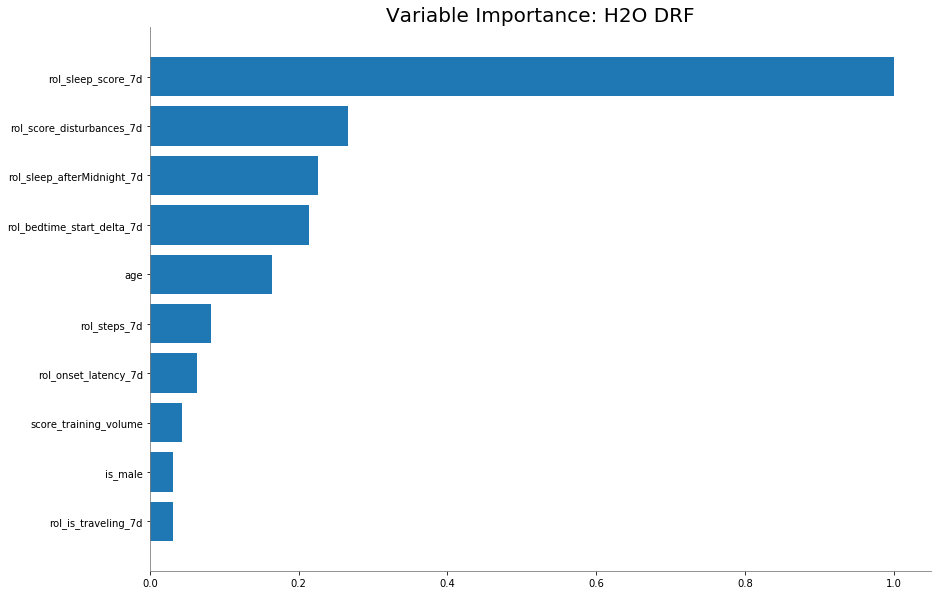

In [138]:
saved_model.varimp_plot()

### The MOJO approach - Shipping a model

This is an important functionality that provides a means to use external, pre-trained models in H2O - mainly for the purpose of scoring. Depending on each external model, metrics and other model information might be obtained as well. 
Importing a MOJO

Importing a MOJO can be done from Python, R, and Flow. H2O imports the model and embraces it for the purpose of scoring. Information output about the model may be limited.
Reference : http://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html#supported-mojos

### Building a MOJO

MOJOs are built in much the same way as POJOs. The  code below shows how to do this.The `download_mojo()` function saves the model as a zip file. We can unzip the file to view the options used to build the file along with each tree built in the model. Note that each tree file is saved as a binary file type.

In [139]:
### CODE SOURCED FROM : http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#mojo-quickstart

# Download the MOJO and the resulting ``h2o-genmodel.jar`` file
# to a new **experiment** folder. Note that the ``h2o-genmodel.jar`` file
# is a library that supports scoring and contains the required readers
# and interpreters. This file is required when MOJO models are deployed
# to production. Be sure to specify the entire path, not just the relative path.
modelfile = aml.leader.download_mojo(path="./", get_genmodel_jar=True)
print("Model saved to " + modelfile)

Model saved to /jupyter/DRF_1_AutoML_20191207_191122.zip


### Compile and Run the MOJO

A detailed step by step implementation approach is provided here : http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#mojo-quickstart
